# DaniO5P CNN training and evaluation

This notebook trains and evaluates an ensemble of convolutional neural networks (CNN). These models take an input sequence and generate predictions of the following 7 quantities:
- log2(MRL_2hpf), log2(MRL_4hpf), log2(MRL_6hpf), log2(MRL_10hpf)
- log2(TPM_input_4hpf) - log2(TPM_input_2hpf), log2(TPM_input_6hpf) - log2(TPM_input_2hpf), log2(TPM_input_10hpf) - log2(TPM_input_2hpf)

Note that the predicted quantities are the *residuals* from the length model and not the actual measurements. To obtain a full prediction on measured quantities, CNN predictions must be added to length model predictions.

Models are trained in a 10-fold cross validation scheme based on chromosome splits: sequences from different chromosomes are used for either training/validation/testing of each model, and every chromosome is in the test set of exactly one model. Chromosome splits are generated in `generate_chr_splits.ipynb`.

After training, predictions are made on the test set of each model and saved to `Zb_5UTR_MPRA_cnn_test_predictions.tsv.gz`. r^2 are calculated based on these predictions and saved to `performance_cnn_test_r2.csv`. Finally, predictions are made using the full ensemble (average output of all models) and saved to `Zb_5UTR_MPRA_cnn_ensemble_predictions.tsv.gz`.

In [41]:
import json
import os
import sys

import numpy
import matplotlib
from matplotlib import pyplot
import pickle
import pandas
import scipy
import seaborn
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import models

utils_dir = '../utils'
sys.path.append(utils_dir)
import custom_plots
import seq_utils
import cnn_vgg

In [42]:
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.sans-serif'] = 'Arial'

# Read data

In [43]:
# Sublibraries
tpm_fraction_list = ['input', '80S', 'LMW', 'HMW']
pol_fraction_list = ['80S', 'LMW', 'HMW']
timepoint_list = [2, 4, 6, 10]

min_input_tpm_col = 'min_TPM_input'

tpm_cols = [f'gmean_TPM_{f}_{t}hpf' for f in tpm_fraction_list for t in timepoint_list]
input_tpm_cols = [f'gmean_TPM_input_{t}hpf' for t in timepoint_list]
input_log2_tpm_cols = [f'log2_TPM_input_{t}hpf' for t in timepoint_list]
diff_log2_tpm_input_cols = [f'diff_log2_TPM_input_{t}-2hpf' for t in timepoint_list[1:]]

mrl_cols = [f'MRL_{t}hpf' for t in timepoint_list]
log2_mrl_cols = [f'log2_MRL_{t}hpf' for t in timepoint_list]
res_log2_mrl_cols = [f'res_log2_MRL_{t}hpf' for t in timepoint_list]

res_diff_log2_tpm_input_cols = [f'res_diff_log2_TPM_input_{t}-2hpf' for t in timepoint_list[1:]]

In [45]:
# Load data
data_full = pandas.read_csv(
    '../00_data/Zb_5UTR_MPRA_TPM_MRL.tsv.gz',
    index_col=0,
    sep='\t',
)
# Add residuals
data_residuals = pandas.read_csv(
    '../01_length_model/Zb_5UTR_MPRA_len_residuals.tsv.gz',
    index_col=0,
    sep='\t',
)
data_full = pandas.concat([data_full, data_residuals], axis=1)

data_full

,chr,strand,external_gene_name,utr_length,insert_length,n_uORFs,GC_content,mxfold,index,index_base,...,log2_MRL_6hpf,MRL_10hpf,log2_MRL_10hpf,res_log2_MRL_2hpf,res_log2_MRL_4hpf,res_log2_MRL_6hpf,res_log2_MRL_10hpf,res_diff_log2_TPM_input_4-2hpf,res_diff_log2_TPM_input_6-2hpf,res_diff_log2_TPM_input_10-2hpf
ENSDARG00000000001_ENSDART00000000004_19058_slc35a5_20318,chr9,-,slc35a5,103,103,2,52.427184,23.9,20318.0,20318,...,2.807965,6.480393,2.696081,-1.399931,-1.088321,-0.755253,-0.941045,-0.076781,-0.251693,-0.468006
ENSDARG00000000018_ENSDART00000181044_14421_nrf1_72681,chr4,-,nrf1,134,134,0,61.940299,35.3,72681.0,72681,...,3.063465,4.441558,2.151066,-0.683110,-0.525705,-0.089619,-0.524812,0.006283,-0.091338,-0.300960
ENSDARG00000000019_ENSDART00000124452_14118_ube2h_27446,chr4,+,ube2h,178,178,1,46.629213,30.1,27446.0,27446,...,2.931009,6.260806,2.646348,-0.018686,0.774950,0.120307,0.886358,-0.328324,0.184831,-0.127470
ENSDARG00000000068_ENSDART00000000069_2438_slc9a3r1a_113092,chr12,+,slc9a3r1a,152,152,0,46.052632,26.1,113092.0,113092,...,3.511713,9.108052,3.187143,0.982463,0.745786,0.532694,0.949547,0.069061,0.182264,0.740350
ENSDARG00000000069_ENSDART00000000070_12170_dap_20320,chr24,-,dap,153,153,1,47.058824,31.8,20320.0,20320,...,3.112192,4.903643,2.293854,-0.020768,-0.055346,0.141463,0.078025,-0.032827,0.004574,0.147751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSDARG00000025554_ENSDART00000103273_1746_wdr83os_27060,chr11,+,wdr83os,126,126,1,37.301587,22.8,27060.0,27060,...,3.014919,20.048542,4.325425,-0.104439,0.456420,-0.230639,1.426489,-0.079539,0.302870,0.052179
ENSDARG00000103318_ENSDART00000161570_7325_mrpl3_86762,chr19,+,mrpl3,111,111,2,34.234234,12.5,86762.0,86762,...,3.047301,12.727341,3.669859,-0.077696,-0.171766,-0.396709,0.305802,0.226216,0.328040,-0.285474
ENSDARG00000036698_ENSDART00000053300_7697_znf865_21263.6,chr19,-,znf865,1305,197,4,31.979695,25.9,21263.6,21263,...,4.095042,7.074025,2.822531,1.327407,1.750233,1.345226,1.295368,-0.290205,0.359827,0.048337
ENSDARG00000056892_ENSDART00000148517_5556_mpp6a_23746.2,chr16,-,mpp6a,311,161,1,39.130435,37.6,23746.2,23746,...,4.315366,16.071784,4.006458,1.001961,1.058925,1.405726,1.954980,-0.194121,-0.078358,-0.003622


In [8]:
# Used later for one-hot encoding
max_seq_len = data_full['insert_length'].max()

,gmean_TPM_80S_2hpf,gmean_TPM_80S_4hpf,gmean_TPM_80S_6hpf,gmean_TPM_80S_10hpf,gmean_TPM_HMW_2hpf,gmean_TPM_HMW_4hpf,gmean_TPM_HMW_6hpf,gmean_TPM_HMW_10hpf,gmean_TPM_LMW_2hpf,gmean_TPM_LMW_4hpf,...,pred_len_log2_MRL_6hpf,res_log2_MRL_6hpf,pred_len_log2_MRL_10hpf,res_log2_MRL_10hpf,pred_len_diff_log2_TPM_input_4-2hpf,res_diff_log2_TPM_input_4-2hpf,pred_len_diff_log2_TPM_input_6-2hpf,res_diff_log2_TPM_input_6-2hpf,pred_len_diff_log2_TPM_input_10-2hpf,res_diff_log2_TPM_input_10-2hpf
ENSDARG00000000001_ENSDART00000000004_19058_slc35a5_20318,216.119597,300.098846,344.106715,206.935398,52.395790,55.702172,59.340141,44.803430,96.196505,132.609072,...,3.563218,-0.755253,3.637126,-0.941045,-0.024803,-0.076781,0.239230,-0.251693,-0.090263,-0.468006
ENSDARG00000000018_ENSDART00000181044_14421_nrf1_72681,51.599266,72.615184,66.370199,72.861548,44.664956,54.740053,68.632506,21.444703,38.973036,45.577612,...,3.153084,-0.089619,2.675878,-0.524812,0.105875,0.006283,0.036108,-0.091338,0.057175,-0.300960
ENSDARG00000000019_ENSDART00000124452_14118_ube2h_27446,25.232864,28.564950,28.856285,18.748520,26.113239,40.141316,34.204028,29.607813,19.380357,32.142153,...,2.810702,0.120307,1.759990,0.886358,0.121639,-0.328324,-0.243822,0.184831,0.069192,-0.127470
ENSDARG00000000068_ENSDART00000000069_2438_slc9a3r1a_113092,46.001865,50.122090,51.030345,84.750185,100.220723,99.442134,83.137348,102.552193,74.144157,70.502780,...,2.979019,0.532694,2.237596,0.949547,0.136392,0.069061,-0.079596,0.182264,0.090065,0.740350
ENSDARG00000000069_ENSDART00000000070_12170_dap_20320,46.019622,63.623896,82.644983,109.283419,35.883390,42.745489,42.463992,19.838702,69.189005,57.990429,...,2.970729,0.141463,2.215829,0.078025,0.137110,-0.032827,-0.085976,0.004574,0.090756,0.147751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSDARG00000005482_ENSDART00000169300_4321_rapgef2_17462.3,29.545491,40.681902,42.027810,50.030592,15.209160,26.571907,25.576338,17.552317,26.966883,34.800351,...,2.889129,-0.257709,1.994331,0.646701,0.138223,-0.244659,-0.155819,0.104111,0.090473,-0.230589
ENSDARG00000037178_ENSDART00000054066_201_zic2b_19629.1,56.263507,70.785671,68.748759,75.274701,67.263862,71.049031,64.634216,29.542642,87.841982,79.027084,...,3.041117,0.374679,2.397575,-0.102787,0.128484,-0.021216,-0.034795,-0.033414,0.081877,0.122644
ENSDARG00000037178_ENSDART00000054066_201_zic2b_19629.2,12.730160,14.300476,22.050854,24.223161,26.545276,26.892093,31.185103,14.666756,25.856685,19.397420,...,3.031810,0.583976,2.373905,0.258985,0.129923,0.045652,-0.041210,0.204776,0.083405,0.426325
ENSDARG00000101903_ENSDART00000168627_8580_zfyve9a_20081.1,89.002050,91.589248,100.399792,143.767244,62.331660,88.351048,89.108929,66.806081,92.982897,99.488904,...,2.946731,0.397144,2.152159,0.435771,0.138648,0.200009,-0.105085,0.312645,0.092114,0.628628


In [46]:
# Preserve only rows with input tpm above threshold
tpm_threshold = 2

data = data_full[data_full[min_input_tpm_col] > tpm_threshold]

print(f"{len(data_full):,} total sequences, {len(data):,} retained.")

data

18,021 total sequences, 17,879 retained.


,chr,strand,external_gene_name,utr_length,insert_length,n_uORFs,GC_content,mxfold,index,index_base,...,log2_MRL_6hpf,MRL_10hpf,log2_MRL_10hpf,res_log2_MRL_2hpf,res_log2_MRL_4hpf,res_log2_MRL_6hpf,res_log2_MRL_10hpf,res_diff_log2_TPM_input_4-2hpf,res_diff_log2_TPM_input_6-2hpf,res_diff_log2_TPM_input_10-2hpf
ENSDARG00000000001_ENSDART00000000004_19058_slc35a5_20318,chr9,-,slc35a5,103,103,2,52.427184,23.9,20318.0,20318,...,2.807965,6.480393,2.696081,-1.399931,-1.088321,-0.755253,-0.941045,-0.076781,-0.251693,-0.468006
ENSDARG00000000018_ENSDART00000181044_14421_nrf1_72681,chr4,-,nrf1,134,134,0,61.940299,35.3,72681.0,72681,...,3.063465,4.441558,2.151066,-0.683110,-0.525705,-0.089619,-0.524812,0.006283,-0.091338,-0.300960
ENSDARG00000000019_ENSDART00000124452_14118_ube2h_27446,chr4,+,ube2h,178,178,1,46.629213,30.1,27446.0,27446,...,2.931009,6.260806,2.646348,-0.018686,0.774950,0.120307,0.886358,-0.328324,0.184831,-0.127470
ENSDARG00000000068_ENSDART00000000069_2438_slc9a3r1a_113092,chr12,+,slc9a3r1a,152,152,0,46.052632,26.1,113092.0,113092,...,3.511713,9.108052,3.187143,0.982463,0.745786,0.532694,0.949547,0.069061,0.182264,0.740350
ENSDARG00000000069_ENSDART00000000070_12170_dap_20320,chr24,-,dap,153,153,1,47.058824,31.8,20320.0,20320,...,3.112192,4.903643,2.293854,-0.020768,-0.055346,0.141463,0.078025,-0.032827,0.004574,0.147751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSDARG00000005482_ENSDART00000169300_4321_rapgef2_17462.3,chr14,-,rapgef2,478,164,0,53.048780,45.5,17462.3,17462,...,2.631420,6.237780,2.641033,-0.711466,-0.007462,-0.257709,0.646701,-0.244659,0.104111,-0.230589
ENSDARG00000037178_ENSDART00000054066_201_zic2b_19629.1,chr1,+,zic2b,281,145,1,40.689655,16.4,19629.1,19629,...,3.415796,4.906818,2.294788,0.436374,0.335923,0.374679,-0.102787,-0.021216,-0.033414,0.122644
ENSDARG00000037178_ENSDART00000054066_201_zic2b_19629.2,chr1,+,zic2b,281,146,1,39.726027,19.3,19629.2,19629,...,3.615786,6.202675,2.632890,0.651445,0.375255,0.583976,0.258985,0.045652,0.204776,0.426325
ENSDARG00000101903_ENSDART00000168627_8580_zfyve9a_20081.1,chr2,-,zfyve9a,304,156,3,41.666667,22.9,20081.1,20081,...,3.343875,6.012355,2.587930,0.388162,0.366879,0.397144,0.435771,0.200009,0.312645,0.628628


Text(0, 0.5, 'Minimum TPM per sequence')

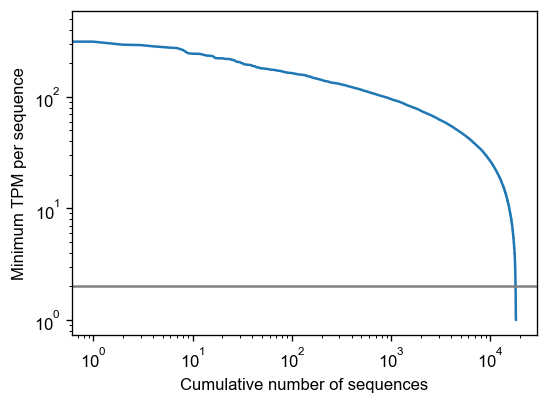

In [48]:
# Plot number of sequences vs. reads
data_tpm_min = data_full[min_input_tpm_col].sort_values(ascending=False)

f, ax = pyplot.subplots(figsize=(5, 3.5))
ax.plot(range(len(data_tpm_min)), data_tpm_min)
ax.axhline(tpm_threshold, color='gray')
ax.set_xscale('log')
ax.set_xlabel('Cumulative number of sequences')
ax.set_yscale('log')
ax.set_ylabel('Minimum TPM per sequence')

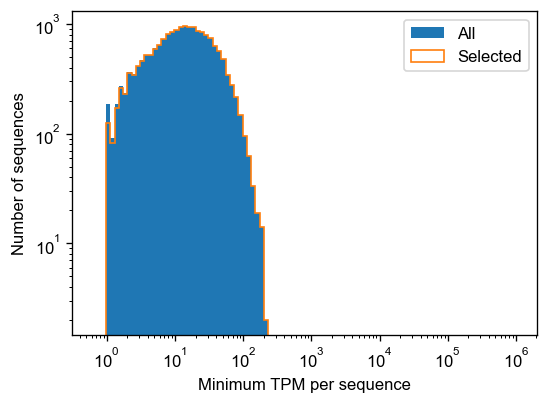

In [49]:
# Plot histogram with number of reads
pyplot.figure(figsize=(5, 3.5))
pyplot.hist(
    data_full.loc[:, tpm_cols].min(axis=1),
    bins=numpy.logspace(-0.2, 6, 100),
    log=True,
    label='All')
pyplot.hist(
    data.loc[:, tpm_cols].min(axis=1),
    bins=numpy.logspace(-0.2, 6, 100),
    log=True,
    label='Selected',
    histtype='step')
pyplot.xscale('log')
pyplot.xlabel('Minimum TPM per sequence')
pyplot.ylabel('Number of sequences')
pyplot.legend()

# Load split info

Produced by the `generate_chr_splits.ipynb` notebook.

In [51]:
with open('chr_splits.json', 'r') as f:
    chr_splits_info = json.load(f)
# chr_splits_info

# Train ensemble model

In [54]:
# Folder for model files
models_dir = 'models_cnn_vgg'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

In [10]:
# Bootstrapping loop
epochs = 100
batch_size = 128
learning_rate = 3e-4

max_seq_len = data_full['insert_length'].max()

for split_idx, chr_split_info in enumerate(chr_splits_info):
    print(f"Training model {split_idx + 1}/{len(chr_splits_info)}...")

    # Split data
    train_chrs = chr_split_info['train']
    val_chrs = chr_split_info['val']
    test_chrs = chr_split_info['test']

    data_train = data[data['chr'].isin(train_chrs)]
    data_val = data[data['chr'].isin(val_chrs)]
    data_test = data[data['chr'].isin(test_chrs)]

    print(f"{len(data_train):,} samples for training, {len(data_val):,} for validation, {len(data_test):,} for testing...")

    model = cnn_vgg.make_model(
        input_seq_len=max_seq_len,
        conv_layers=3,
        conv_kernel_size=7,
        conv_activation='relu',
        conv_filters_first=128,
        conv_dropout=0.1,
        dense_units=[150],
        dense_activation=['relu'],
        dense_dropout=[0.0],
        n_outputs=len(res_log2_mrl_cols + res_diff_log2_tpm_input_cols),
        layer_name_suffix=f'_chr_split_{split_idx:03d}',
    )

    # model.summary()

    # Extract input, output in the preferred format for model
    data_train_x = seq_utils.one_hot_encode(data_train['insert_seq'], max_seq_len=max_seq_len, padding='right', mask_val=0)
    data_train_y = data_train[res_log2_mrl_cols + res_diff_log2_tpm_input_cols].values

    data_val_x = seq_utils.one_hot_encode(data_val[('insert_seq')], max_seq_len=max_seq_len, padding='right', mask_val=0)
    data_val_y = data_val[res_log2_mrl_cols + res_diff_log2_tpm_input_cols].values

    # Use Adam optimizer with decayed learning rate
    # lr = initial_lr / (1 + decay_rate * step / decay_step)
    # At 10 epochs, lr is 1/2 of initial
    # At 20 epochs, lr is 1/3 of initial
    # At 30 epochs, lr is 1/4 of initial
    lr_schedule = tensorflow.keras.optimizers.schedules.InverseTimeDecay(
        learning_rate,
        decay_steps=len(data_train)/batch_size*10,
        decay_rate=1,
        staircase=False,
    )
    optimizer = tensorflow.keras.optimizers.Adam(lr_schedule)

    # Callback: stop training after no improvement in validation
    callbacks = [
        tensorflow.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
        ),
    ]

    model.compile(loss='mean_squared_error', optimizer=optimizer)

    # Train
    training_history = model.fit(
        data_train_x,
        data_train_y,
        validation_data=(data_val_x, data_val_y),
        batch_size=batch_size,
        epochs=epochs,
        shuffle=True,
        callbacks=callbacks,
        verbose=1,
    )

    # Save model
    model_path = os.path.join(models_dir, f'model_{split_idx:03d}.h5')
    model.save(model_path)
    print(f"Model saved to {model_path}.")
        
    # Save training loss plot
    fig, ax = pyplot.subplots(1, 1, figsize=(4, 4))
    n_epochs_actual = len(training_history.history['loss'])
    ax.plot(
        numpy.arange(1, n_epochs_actual + 1),
        training_history.history['loss'],
        marker='o',
        label='Training',
    )
    ax.plot(
        numpy.arange(1, n_epochs_actual + 1),
        training_history.history['val_loss'],
        marker='o',
        label='Validation',
    )
    ax.set_yscale('log')
    ax.set_ylim(0.01, 1)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend()
    fig.savefig(os.path.join(models_dir, f'model_{split_idx:03d}_training.png'), dpi=200, bbox_inches='tight')
    pyplot.close(fig)

    print(f"Done with model {split_idx + 1}/{len(chr_splits_info)}.")
    print()
        
print("Done.")

Training model 1/10...
14,659 samples for training, 1,593 for validation, 1,627 for testing...
Extension horovod.torch has not been built: /home/ec2-user/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2023-09-11 03:29:02.368 ip-172-31-21-153.us-west-2.compute.internal:5884 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-09-11 03:29:02.427 ip-172-31-21-153.us-west-2.compute.internal:5884 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Epoch 1/100
115/115 [==============================] - 18s 81ms/step - loss: 0.2587 - val_loss: 0.2537
Epoch 2/100
115/115 [==============================] - 6s 54ms/step - loss: 0.2311 - val_loss: 0.2135
Epo

# Make average model

In [11]:
# Input
model_input = layers.Input(shape=(None, 4))
model_list = []
model_outputs = []

# Load models
for split_idx, chr_split_info in enumerate(chr_splits_info):
    model_path = os.path.join(models_dir, f'model_{split_idx:03d}.h5')
    
    model = cnn_vgg.load_model(model_path)
    model_list.append(model)
    
    model_output = model(model_input)
    model_outputs.append(model_output)
    
# Model output: average of bs model outputs
model_bs_output = layers.Average()(model_outputs)

# Define bootstrapped model
model_bs = models.Model(
    model_input,
    model_bs_output,
)
model_bs.save(os.path.join(models_dir, f'model_avg.h5'))

# Evaluate models

To get precise performance metrics, evaluation is run on a held-out test dataset which is different for each of the 10 models. These are reported in Figure 5.

In [55]:
# Load models
model_list = []
for split_idx, chr_split_info in enumerate(chr_splits_info):
    model_path = os.path.join(models_dir, f'model_{split_idx:03d}.h5')
    
    model = cnn_vgg.load_model(model_path)
    model_list.append(model)
    
model_list

In [56]:
# Add CNN predictions to data
# For each model, predict only on its test set given by its chromosomal split
# Compute performance metrics too

r2_list = []

for split_idx, chr_split_info in enumerate(chr_splits_info):
    print(f"Evaluating model trained on data split {split_idx}...")

    # Select data from test chromosomes
    test_chrs = chr_split_info['test']
    data_test = data[data['chr'].isin(test_chrs)]

    data_test_x = seq_utils.one_hot_encode(data_test['insert_seq'], max_seq_len=max_seq_len, padding='right', mask_val=0)
    data_test_y = data_test[res_log2_mrl_cols + res_diff_log2_tpm_input_cols].values

    # Load model and generate prediction
    model = model_list[split_idx]
    data_test_y_pred = model.predict(data_test_x)
    
    # Add to dataframe
    for output_idx, output_name in enumerate(log2_mrl_cols + diff_log2_tpm_input_cols):
        data.loc[data_test.index, 'pred_cnn_test_' + output_name] = data_test_y_pred[:, output_idx]

    # Calculate r^2 on each output
    r2_outputs_list = []
    for output_idx, output_label in enumerate(res_log2_mrl_cols + res_diff_log2_tpm_input_cols):
        # Calculate overall R^2
        lrres = scipy.stats.linregress(
            data_test_y[:, output_idx],
            data_test_y_pred[:, output_idx],
        )
        r2_outputs_list.append(lrres.rvalue**2)
    r2_list.append(r2_outputs_list)

r2_test_df = pandas.DataFrame(r2_list, columns=res_log2_mrl_cols + res_diff_log2_tpm_input_cols)
r2_test_df

Evaluating model trained on data split 0...
Evaluating model trained on data split 1...


C:\Users\casti\AppData\Local\Temp\ipykernel_33612\1682184621.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[data_test.index, 'pred_cnn_test_' + output_name] = data_test_y_pred[:, output_idx]
C:\Users\casti\AppData\Local\Temp\ipykernel_33612\1682184621.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[data_test.index, 'pred_cnn_test_' + output_name] = data_test_y_pred[:, output_idx]
C:\Users\casti\AppData\Local\Temp\ipykernel_33612\1682184621.py:23: SettingWithCopyWarning: 
A value

Evaluating model trained on data split 2...
Evaluating model trained on data split 3...
Evaluating model trained on data split 4...
Evaluating model trained on data split 5...
Evaluating model trained on data split 6...
Evaluating model trained on data split 7...
Evaluating model trained on data split 8...
Evaluating model trained on data split 9...


,res_log2_MRL_2hpf,res_log2_MRL_4hpf,res_log2_MRL_6hpf,res_log2_MRL_10hpf,res_diff_log2_TPM_input_4-2hpf,res_diff_log2_TPM_input_6-2hpf,res_diff_log2_TPM_input_10-2hpf
0,0.525931,0.449472,0.441757,0.555202,0.217278,0.390469,0.523377
1,0.516527,0.414872,0.434893,0.512143,0.258745,0.410006,0.563014
2,0.513285,0.457112,0.444111,0.534766,0.253514,0.386817,0.523259
3,0.435870,0.369466,0.377418,0.548283,0.238036,0.434247,0.575866
4,0.482632,0.394868,0.408098,0.526490,0.254024,0.390855,0.552261
5,0.499485,0.389470,0.407845,0.520957,0.246639,0.378605,0.538473
6,0.484146,0.423948,0.405777,0.480046,0.287208,0.404605,0.555840
7,0.484917,0.410671,0.413438,0.528327,0.273239,0.420116,0.558172
8,0.486127,0.399737,0.401789,0.488238,0.277362,0.417996,0.516102
9,0.482497,0.402168,0.388923,0.506046,0.246076,0.402659,0.540376


In [57]:
# Save performance metrics
r2_test_df.to_csv('performance_cnn_test_r2.csv')
r2_test_df

,res_log2_MRL_2hpf,res_log2_MRL_4hpf,res_log2_MRL_6hpf,res_log2_MRL_10hpf,res_diff_log2_TPM_input_4-2hpf,res_diff_log2_TPM_input_6-2hpf,res_diff_log2_TPM_input_10-2hpf
0,0.525931,0.449472,0.441757,0.555202,0.217278,0.390469,0.523377
1,0.516527,0.414872,0.434893,0.512143,0.258745,0.410006,0.563014
2,0.513285,0.457112,0.444111,0.534766,0.253514,0.386817,0.523259
3,0.435870,0.369466,0.377418,0.548283,0.238036,0.434247,0.575866
4,0.482632,0.394868,0.408098,0.526490,0.254024,0.390855,0.552261
5,0.499485,0.389470,0.407845,0.520957,0.246639,0.378605,0.538473
6,0.484146,0.423948,0.405777,0.480046,0.287208,0.404605,0.555840
7,0.484917,0.410671,0.413438,0.528327,0.273239,0.420116,0.558172
8,0.486127,0.399737,0.401789,0.488238,0.277362,0.417996,0.516102
9,0.482497,0.402168,0.388923,0.506046,0.246076,0.402659,0.540376


In [65]:
# Plot performance per ensemble member
for split_idx, chr_split_info in enumerate(chr_splits_info):
    print(f"Evaluating model trained on data split {split_idx}...")

    # Select data from test chromosomes
    test_chrs = chr_split_info['test']
    data_test = data[data['chr'].isin(test_chrs)]
    
    # Plot
    fig, axes = pyplot.subplots(
        3,
        len(timepoint_list),
        figsize=(3*len(timepoint_list), 3*3),
    )
    
    for y_idx, ycol in enumerate(log2_mrl_cols):
        ax = axes[0, y_idx]

        lrres = custom_plots.plot_scatter_shaded(
            data_test['res_' + ycol],
            data_test['pred_cnn_test_' + ycol],
            ax,
            xlim=(-3.5, 3),
            ylim=(-3.5, 3),
            linreg=True,
        )

        ax.set_xlabel('Observed residual log2_MRL')
        if y_idx==0:
            ax.set_ylabel('Predicted residual log2_MRL')
    
    axes[1, 0].set_visible(False)
    for y_idx, ycol in enumerate(log2_mrl_cols[1:]):
        ax = axes[1, y_idx+1]

        lrres = custom_plots.plot_scatter_shaded(
            data_test['res_' + ycol] - data_test['res_' + log2_mrl_cols[0]],
            data_test['pred_cnn_test_' + ycol] - data_test['pred_cnn_test_' + log2_mrl_cols[0]],
            ax,
            xlim=(-4, 4),
            ylim=(-4, 4),
            linreg=True,
        )

        ax.set_xlabel('Observed residual Δlog2_TPM_input')
        if y_idx==0:
            ax.set_ylabel('Predicted residual Δlog2_TPM_input')

        full_ycol = 'diff_' + ycol[:-3] + '-2hpf'
    
    axes[2, 0].set_visible(False)
    for y_idx, ycol in enumerate(diff_log2_tpm_input_cols):
        ax = axes[2, y_idx+1]

        lrres = custom_plots.plot_scatter_shaded(
            data_test['res_' + ycol],
            data_test['pred_cnn_test_' + ycol],
            ax,
            xlim=(-2.5, 2),
            ylim=(-2.5, 2),
            linreg=True,
        )

        ax.set_xlabel('Observed residual Δlog2_TPM_input')
        if y_idx==0:
            ax.set_ylabel('Predicted residual Δlog2_TPM_input')

    # fig.savefig(os.path.join(models_dir, f'model_{split_idx:03d}_performance.png'), dpi=200, bbox_inches='tight')
    fig.savefig(os.path.join(models_dir, f'model_{split_idx:03d}_performance.svg'), dpi=200, bbox_inches='tight')
    pyplot.close(fig)

Evaluating model trained on data split 0...
Evaluating model trained on data split 1...
Evaluating model trained on data split 2...
Evaluating model trained on data split 3...
Evaluating model trained on data split 4...
Evaluating model trained on data split 5...
Evaluating model trained on data split 6...
Evaluating model trained on data split 7...
Evaluating model trained on data split 8...
Evaluating model trained on data split 9...


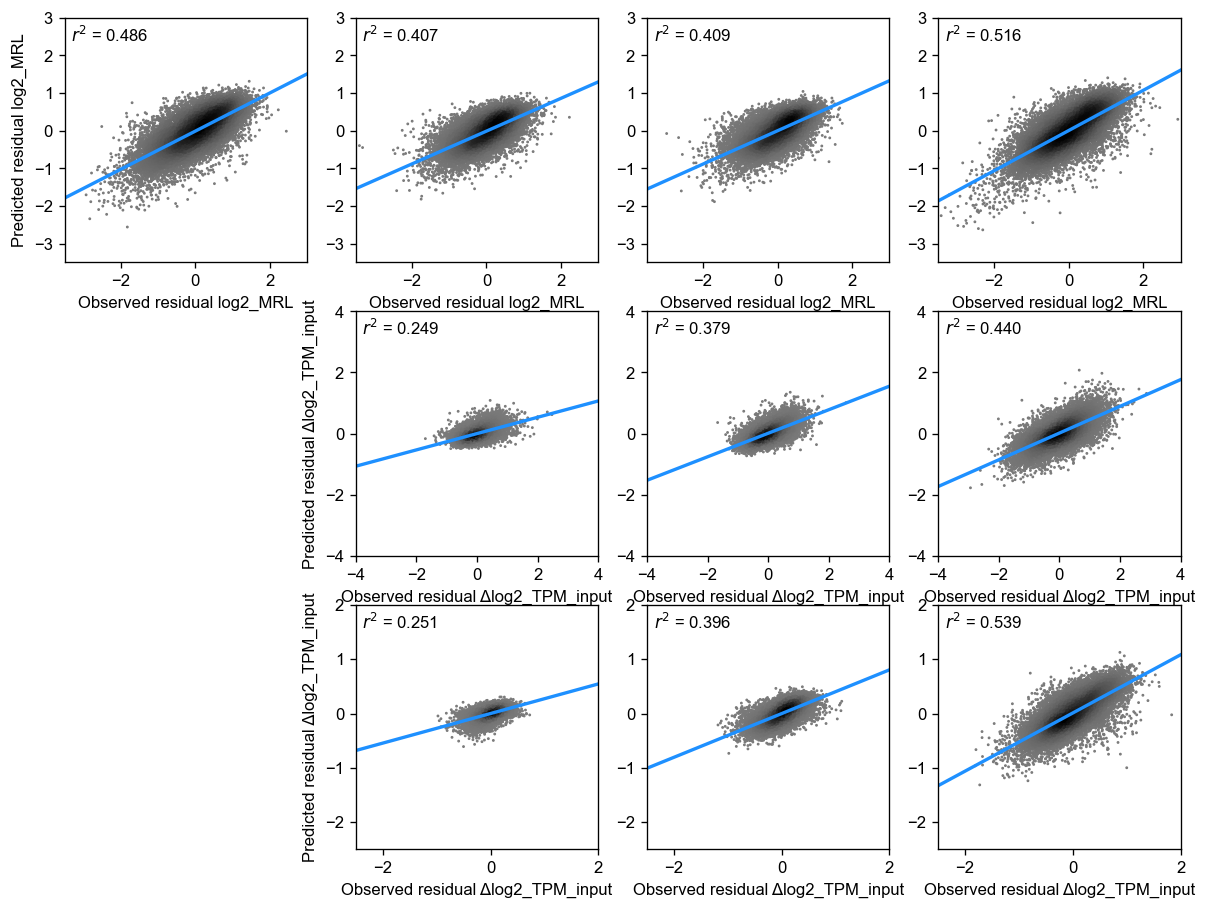

In [66]:
# Plot performance combining all predictions
fig, axes = pyplot.subplots(
    3,
    len(timepoint_list),
    figsize=(3*len(timepoint_list), 3*3),
)

for y_idx, ycol in enumerate(log2_mrl_cols):
    ax = axes[0, y_idx]

    lrres = custom_plots.plot_scatter_shaded(
        data['res_' + ycol],
        data['pred_cnn_test_' + ycol],
        ax,
        xlim=(-3.5, 3),
        ylim=(-3.5, 3),
        linreg=True,
    )

    ax.set_xlabel('Observed residual log2_MRL')
    if y_idx==0:
        ax.set_ylabel('Predicted residual log2_MRL')

axes[1, 0].set_visible(False)
for y_idx, ycol in enumerate(log2_mrl_cols[1:]):
    ax = axes[1, y_idx+1]

    lrres = custom_plots.plot_scatter_shaded(
        data['res_' + ycol] - data['res_' + log2_mrl_cols[0]],
        data['pred_cnn_test_' + ycol] - data['pred_cnn_test_' + log2_mrl_cols[0]],
        ax,
        xlim=(-4, 4),
        ylim=(-4, 4),
        linreg=True,
    )

    ax.set_xlabel('Observed residual Δlog2_TPM_input')
    if y_idx==0:
        ax.set_ylabel('Predicted residual Δlog2_TPM_input')

    full_ycol = 'diff_' + ycol[:-3] + '-2hpf'

axes[2, 0].set_visible(False)
for y_idx, ycol in enumerate(diff_log2_tpm_input_cols):
    ax = axes[2, y_idx+1]

    lrres = custom_plots.plot_scatter_shaded(
        data['res_' + ycol],
        data['pred_cnn_test_' + ycol],
        ax,
        xlim=(-2.5, 2),
        ylim=(-2.5, 2),
        linreg=True,
    )

    ax.set_xlabel('Observed residual Δlog2_TPM_input')
    if y_idx==0:
        ax.set_ylabel('Predicted residual Δlog2_TPM_input')

# fig.savefig(f'model_cnn_test_performance.png', dpi=200, bbox_inches='tight')
fig.savefig(f'model_all_test_performance.svg', dpi=200, bbox_inches='tight')

In [64]:
# Save CNN predictions on the test set
data_pred_cnn_test = data[['pred_cnn_test_' + c for c in log2_mrl_cols + diff_log2_tpm_input_cols]]
data_pred_cnn_test.to_csv('Zb_5UTR_MPRA_cnn_test_predictions.tsv.gz', sep='\t', compression='gzip')
data_pred_cnn_test

,pred_cnn_test_log2_MRL_2hpf,pred_cnn_test_log2_MRL_4hpf,pred_cnn_test_log2_MRL_6hpf,pred_cnn_test_log2_MRL_10hpf,pred_cnn_test_diff_log2_TPM_input_4-2hpf,pred_cnn_test_diff_log2_TPM_input_6-2hpf,pred_cnn_test_diff_log2_TPM_input_10-2hpf
ENSDARG00000000001_ENSDART00000000004_19058_slc35a5_20318,-1.458773,-1.093876,-0.951683,-1.036844,-0.101084,-0.345722,-0.879938
ENSDARG00000000018_ENSDART00000181044_14421_nrf1_72681,-0.432712,-0.186677,-0.095012,-0.102925,-0.160784,-0.123861,-0.039520
ENSDARG00000000019_ENSDART00000124452_14118_ube2h_27446,0.483113,0.524021,0.625693,0.616004,-0.023491,0.085291,0.157075
ENSDARG00000000068_ENSDART00000000069_2438_slc9a3r1a_113092,0.573451,0.308855,0.327263,0.303263,0.005142,0.124859,0.412762
ENSDARG00000000069_ENSDART00000000070_12170_dap_20320,-0.150332,0.134495,0.041598,0.153033,-0.004480,0.090186,0.256218
...,...,...,...,...,...,...,...
ENSDARG00000005482_ENSDART00000169300_4321_rapgef2_17462.3,-0.229026,0.144449,0.270178,0.420581,-0.201801,-0.068943,0.175988
ENSDARG00000037178_ENSDART00000054066_201_zic2b_19629.1,0.486780,0.350007,0.346714,0.241248,0.018923,0.159062,0.308922
ENSDARG00000037178_ENSDART00000054066_201_zic2b_19629.2,0.369464,0.087115,0.103181,-0.209837,0.116786,0.044556,0.175206
ENSDARG00000101903_ENSDART00000168627_8580_zfyve9a_20081.1,0.260718,0.103335,0.274023,0.036972,0.114199,0.056542,0.037466


# Generate model ensemble predictions

Here we generate predictions for all sequences using the average of the individual model outputs.

In [67]:
# Add ensemble predictions
# Add ensemble CNN predictions
data_x = seq_utils.one_hot_encode(data['insert_seq'], max_seq_len=max_seq_len, padding='right', mask_val=0)

model_preds = []
for model_idx, model in enumerate(model_list):
    data_y_pred = model.predict(data_x)
    model_preds.append(data_y_pred)

# Average predictions
data_y_pred = numpy.mean(model_preds, axis=0)

# Add to dataframe
for output_idx, output_name in enumerate(log2_mrl_cols + diff_log2_tpm_input_cols):
    data['pred_cnn_ens_' + output_name] = data_y_pred[:, output_idx]

C:\Users\casti\AppData\Local\Temp\ipykernel_33612\834980274.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pred_cnn_ens_' + output_name] = data_y_pred[:, output_idx]


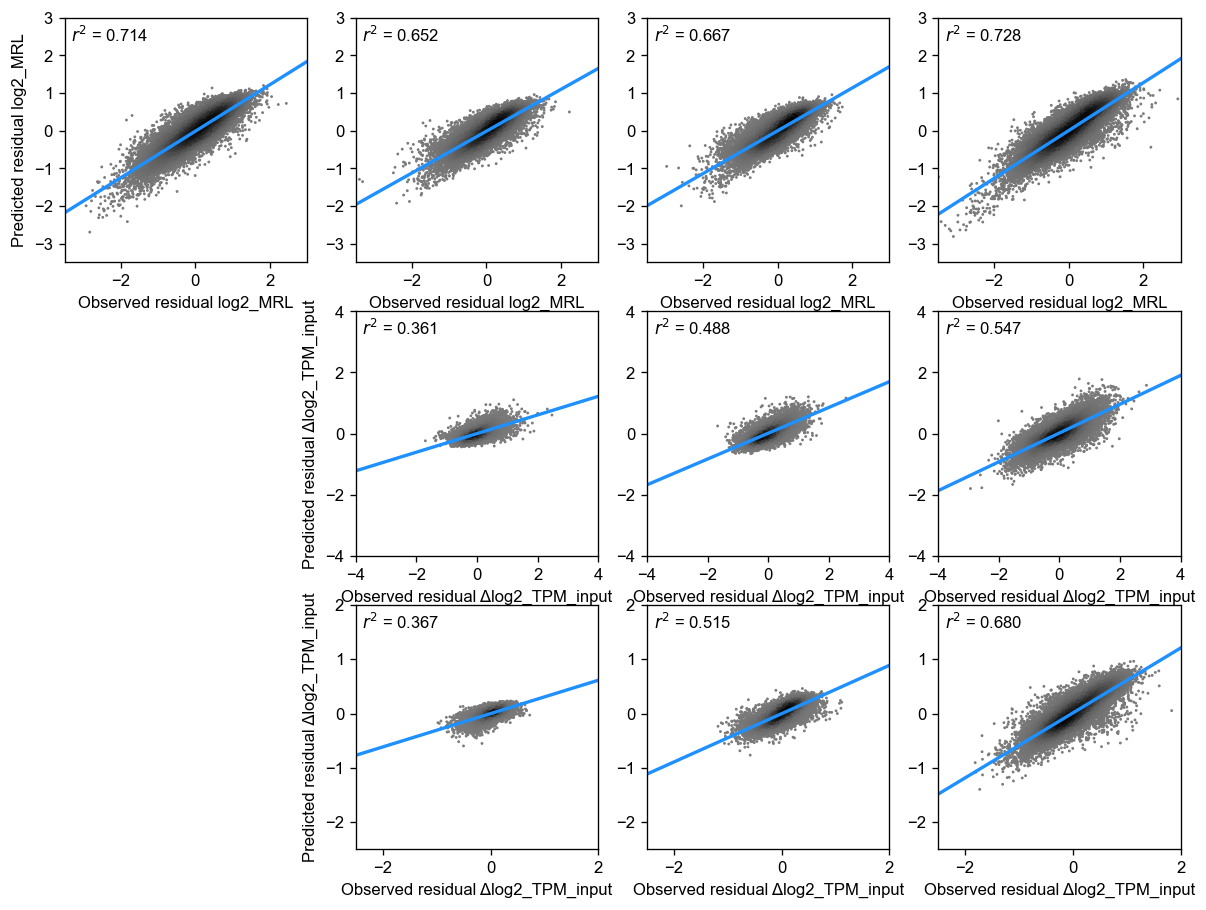

In [68]:
# Plot ensemble model performance
fig, axes = pyplot.subplots(
    3,
    len(timepoint_list),
    figsize=(3*len(timepoint_list), 3*3),
)

for y_idx, ycol in enumerate(log2_mrl_cols):
    ax = axes[0, y_idx]

    lrres = custom_plots.plot_scatter_shaded(
        data['res_' + ycol],
        data['pred_cnn_ens_' + ycol],
        ax,
        xlim=(-3.5, 3),
        ylim=(-3.5, 3),
        linreg=True,
    )

    ax.set_xlabel('Observed residual log2_MRL')
    if y_idx==0:
        ax.set_ylabel('Predicted residual log2_MRL')

axes[1, 0].set_visible(False)
for y_idx, ycol in enumerate(log2_mrl_cols[1:]):
    ax = axes[1, y_idx+1]

    lrres = custom_plots.plot_scatter_shaded(
        data['res_' + ycol] - data['res_' + log2_mrl_cols[0]],
        data['pred_cnn_ens_' + ycol] - data['pred_cnn_ens_' + log2_mrl_cols[0]],
        ax,
        xlim=(-4, 4),
        ylim=(-4, 4),
        linreg=True,
    )

    ax.set_xlabel('Observed residual Δlog2_TPM_input')
    if y_idx==0:
        ax.set_ylabel('Predicted residual Δlog2_TPM_input')

    full_ycol = 'diff_' + ycol[:-3] + '-2hpf'

axes[2, 0].set_visible(False)
for y_idx, ycol in enumerate(diff_log2_tpm_input_cols):
    ax = axes[2, y_idx+1]

    lrres = custom_plots.plot_scatter_shaded(
        data['res_' + ycol],
        data['pred_cnn_ens_' + ycol],
        ax,
        xlim=(-2.5, 2),
        ylim=(-2.5, 2),
        linreg=True,
    )

    ax.set_xlabel('Observed residual Δlog2_TPM_input')
    if y_idx==0:
        ax.set_ylabel('Predicted residual Δlog2_TPM_input')

# fig.savefig(f'model_cnn_ensemble_performance.png', dpi=200, bbox_inches='tight')
fig.savefig(f'model_cnn_ensemble_performance.svg', dpi=200, bbox_inches='tight')

In [69]:
# Save spreadsheet with predictions
data_pred_cnn_ens = data[['pred_cnn_ens_' + c for c in log2_mrl_cols + diff_log2_tpm_input_cols]]
data_pred_cnn_ens.to_csv('Zb_5UTR_MPRA_cnn_ensemble_predictions.tsv.gz', sep='\t', compression='gzip')